# ADAroundTheWorld2023 - Milestone 3

## Imports

In [52]:
import warnings
import itertools

import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from scripts.helpers import get_list_from_string_dict, get_similarities_from_json, get_similarity_df, \
    get_graph_from_pickle, merge_graph_to_df, get_probabilities_from_json
from scripts.plotting import plot_example_graph, plot_similarity_matrix, plot_bokeh_graph

from bokeh.io import show
from bokeh.io.export import get_screenshot_as_png

warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

## Table of Contents

Please do not try to click on them in GitHub as GitHub renders it differently and the links only work locally.

&emsp;&ensp;&ensp;[Abstract](#abstract)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[1 - Preprocessing & Initial Analysis](#preprocess)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.1 - Preprocessing](#preprocessing-child)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.2 - Merging](#merging)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.3 - First Glance](#first-glance)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[2 - Theory of Centrality Metrics](#theory)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.1 - Betweenness](#betweenness)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.2 - Degree](#degree)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[3 - Creating Network Graphs](#creating-network)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.1 - Embeddings](#embeddings)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.1 - Classification](#classification)<br style="margin-bottom:0.1em;">
&emsp;&emsp;[4 - Correlation Analysis](#correlation-analysis)<br style="margin-bottom:0.1em;">
&emsp;&ensp;&ensp;[Summary](#summary)<br style="margin-bottom:0.1em;">


## Abstract <a class="anchor" id="abstract"></a>

This notebook is a ...

## 1. Preprocessing & Initial Analysis <a class="anchor" id="preprocess"></a>

TBD

### 1.1 Preprocessing <a class="anchor" id="preprocessing-child"></a>

TBD

### 1.1.1 Movie Metadata

In [3]:
# specify the column names 
column_names = [
    'wikipedia_id', 'freebase_id', 'name', 'release_date', 
    'box_office_revenue', 'runtime', 'languages', 'countries', 'genres'
]
metadata_df = pd.read_table('data/raw/movie.metadata.tsv', names=column_names)
print(metadata_df.shape)
metadata_df.head(5)

(81741, 9)


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Few things come up first that needs to be done:
1. release date has **inconsistent formatting** -> let's use only year
2. we **don't need box-office revenue and runtime** for the analysis -> let's drop them
3. languages, countries and genres have **inconvenient formatting** -> let's fix that

In [4]:
# let's first check how many missing values do we have in release date
missing_perc_date = metadata_df.release_date.isna().sum() / metadata_df.shape[0] * 100
print(f'We have missing year for {round(missing_perc_date, 1)}% of data.')

We have missing year for 8.4% of data.


In [5]:
# let's now convert string to date
metadata_df['release_year'] = pd.to_datetime(metadata_df['release_date'], errors='coerce')

# remove the original column
# plus there might be some with inconsistent formatting in the newly created column
metadata_df.drop(columns='release_date', inplace=True)
metadata_df.dropna(subset=['release_year'], inplace=True)

# and now convert it to year as integer
metadata_df['release_year'] = metadata_df['release_year'].dt.year.astype(int)

metadata_df.head(5)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [6]:
# let's remove unnecessary columns
metadata_df.drop(columns=['box_office_revenue', 'runtime'], inplace=True)

In [7]:
# convert columns genres, languages and countries to list of strings
metadata_df['genres'] = metadata_df.genres.apply(get_list_from_string_dict)
metadata_df['languages'] = metadata_df.languages.apply(get_list_from_string_dict)
metadata_df['countries'] = metadata_df.countries.apply(get_list_from_string_dict)

metadata_df[['genres', 'languages', 'countries']].head(5)

,genres,languages,countries
0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America]
1,"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],[United States of America]
2,"[Crime Fiction, Drama]",[Norwegian Language],[Norway]
3,"[Thriller, Erotic thriller, Psychological thri...",[English Language],[United Kingdom]
4,[Drama],[German Language],[Germany]


In [8]:
# let's now check the null-s 
print("Number of rows {}:".format(metadata_df.shape[0]))
(~metadata_df.astype(bool)).sum()

Number of rows 74838:


wikipedia_id        0
freebase_id         0
name                0
languages       10009
countries        5228
genres           1762
release_year        0
dtype: int64

Such method was used for checking nulls because `languages`, `countries` and `genres` might simply be empty lists.
As languages nor countries are in the principal role in the following analysis (we might not use them at all), 
we can keep them as they are for now and decide the strategy if need be.

### 1.1.2 Plot Summaries    

In [9]:
# let's read the file
plot_column_names = ['wikipedia_id', 'plot']
plot_df = pd.read_csv('data/raw/plot_summaries.txt', sep="\t", names=plot_column_names)
print(plot_df.shape)
plot_df.head(5)

(42303, 2)


,wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [10]:
# let's check nan-s here
plot_df.isna().sum()

wikipedia_id    0
plot            0
dtype: int64

In [11]:
# check if any of the columns is not empty string in plots
empty_plots = (plot_df['plot'].apply(len) == 0).sum()
print(f'We have {empty_plots} plots that have empty plot description.')

We have 0 plots that have empty plot description.


### 1.1.3 IMDB Ratings

For IMDB, we need two files `title.ratings.tsv` and `title.basics.tsv`.

In [12]:
imdb_basics_df = pd.read_csv('data/raw/title.basics.tsv', sep='\t', low_memory=False)
print(imdb_basics_df.shape)
imdb_basics_df.head(5)

(10306126, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [13]:
imdb_ratings_df = pd.read_csv('data/raw/title.ratings.tsv', sep='\t')
print(imdb_ratings_df.shape)
imdb_ratings_df.head(5)

(1367781, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In order to add ratings, we need first to merge two IMDB df-s.

In [14]:
# let's first keep only necessary titles
imdb_basics_df = imdb_basics_df[imdb_basics_df.titleType == 'movie']

# let's keep only necessary columns
imdb_basics_df = imdb_basics_df[['tconst', 'originalTitle', 'startYear']]

In [15]:
# now we can merge the two
imdb_df = pd.merge(imdb_basics_df, imdb_ratings_df, on='tconst', how='inner')
print(imdb_df.shape)
imdb_df.head(5)

(299786, 5)


,tconst,originalTitle,startYear,averageRating,numVotes
0,tt0000009,Miss Jerry,1894,5.3,207
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,5.3,484
2,tt0000502,Bohemios,1905,4.1,15
3,tt0000574,The Story of the Kelly Gang,1906,6.0,855
4,tt0000591,L'enfant prodigue,1907,5.0,21


In [16]:
# we don't need tconst anymore, let's drop it
imdb_df.drop(columns='tconst', inplace=True)

# let's rename the columns to avoid camelcase and sync with other df-s
imdb_df.rename(
    columns={
        'originalTitle': 'name',
        'startYear': 'release_year',
        'averageRating': 'rating',
        'numVotes': 'num_votes'
    },
    inplace=True
)

# let's fix some dtypes
imdb_df.release_year = pd.to_numeric(imdb_df.release_year, errors='coerce', downcast='integer')
imdb_df.dropna(subset='release_year', inplace=True)

imdb_df.name = imdb_df.name.astype(str)

In [17]:
# let's check nulls per column
imdb_df.isna().sum()

name            0
release_year    0
rating          0
num_votes       0
dtype: int64

### 1.2 Merging <a class="anchor" id="merging"></a>

Now that we have all the datasets preprocessed, let's merge them.

In [18]:
# merge plots with metadata
movies_plots_df = pd.merge(plot_df, metadata_df, on='wikipedia_id', how='inner')
movies_plots_df.head(5)

,wikipedia_id,plot,freebase_id,name,languages,countries,genres,release_year
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,[Russian Language],"[France, Soviet Union, Russia]","[Drama, World cinema]",1990
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,[English Language],[United States of America],"[Action/Adventure, Science Fiction, Action, Dr...",2012
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,[Malayalam Language],[India],"[Musical, Action, Drama, Bollywood]",2000
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,[English Language],[United States of America],"[Screwball comedy, Comedy]",1951
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,[English Language],"[United States of America, Australia, New Zeal...","[Crime Fiction, Drama, Docudrama, World cinema...",1988


Since we need to use the year and movie name for merging, we first need to check if there are any duplicates in the year-name pairs. If there are some, we’d need to remove them as we cannot be sure without manually going through all of them, which one is correct.

In [19]:
# drop duplicated keys
movies_plots_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)
imdb_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)

In [20]:
# let's create lowercase titles for merging
movies_plots_df['name_lowercase'] = movies_plots_df.name.str.lower()
imdb_df['name_lowercase'] = imdb_df.name.str.lower()

# let's now merge
df = pd.merge(imdb_df, movies_plots_df, on=['name_lowercase', 'release_year'], how='inner')

# and now deal with lowecase names
df.drop(columns=['name_lowercase', 'name_y'], inplace=True)
df.rename(columns={'name_x': 'name'}, inplace=True)

print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],[Sports]
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,[Silent film],[Australia],"[Silent film, Drama]"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,[Silent film],[],[Silent film]


We now have finished with preprocessing and have 22394 rows with all the necessary data.

### 1.3 First Glance <a class="anchor" id="first-glance"></a>

Let's now understand the nature of our data and start with the descriptive statistics.

In [22]:
df.describe()

,release_year,rating,num_votes,wikipedia_id
count,22394.000000,22394.000000,2.239400e+04,2.239400e+04
mean,1982.243190,6.181531,2.651533e+04,1.309584e+07
std,25.264013,1.112262,1.033211e+05,1.093448e+07
min,1894.000000,1.200000,5.000000e+00,3.217000e+03
25%,1963.000000,5.600000,3.632500e+02,3.055782e+06
50%,1990.000000,6.300000,1.674000e+03,1.005270e+07
75%,2004.000000,6.900000,9.244000e+03,2.294357e+07
max,2014.000000,9.700000,2.816967e+06,3.749236e+07


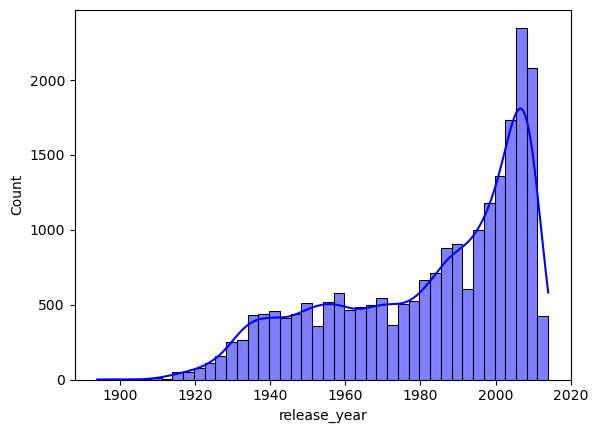

In [23]:
# plot the movie counts by year
_ = sns.histplot(df.release_year, kde=True, color='blue', label='treated')

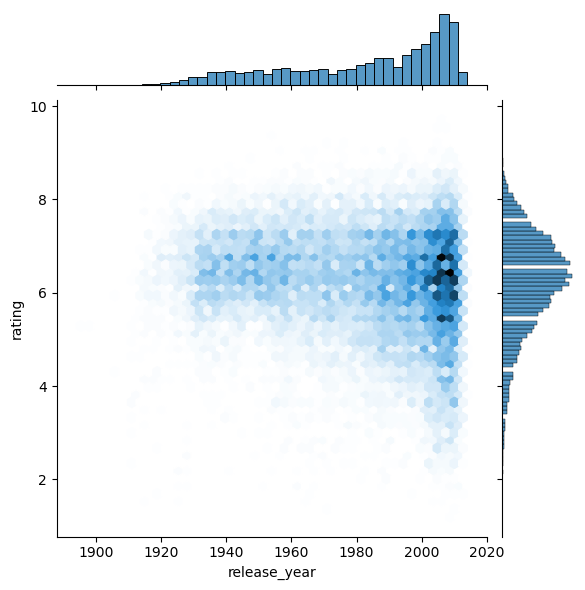

In [24]:
# let's see compare the IMDB rating with the year
_ = sns.jointplot(data=df, x='release_year', y='rating', kind='hex')

## 2. Theory of Centrality Metrics <a class="anchor" id="theory"></a>

TBD

### 2.1 Betweenness <a class="anchor" id="betweenness"></a>

TBD

In [24]:
G = nx.Graph()

# let's define edges
edges = [
    ('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'd'), ('c', 'e'), ('b', 'e'),
    ('f', 'e'), ('f', 'h'), ('f', 'g'), ('g', 'h'), ('b', 'd'), ('i', 'g'),
    ('i', 'f'), ('h', 'e'), ('g', 'e')
]

for node_1, node_2 in edges:
    G.add_edge(node_1, node_2)

ValueError: Could not save to JPEG for display

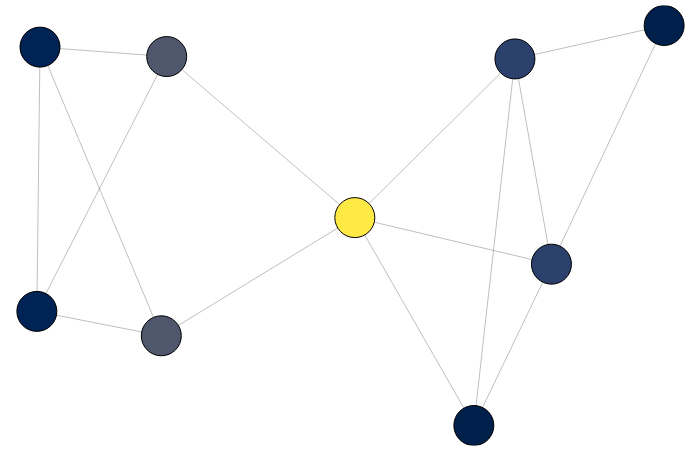

In [55]:
figure_kwargs = {
    'width': 700,
    'height': 450,
    'tooltips': [("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(G, 'betweenness', **figure_kwargs)
get_screenshot_as_png(plot)

### 2.1 Degree <a class="anchor" id="degree"></a>

TBD

In [64]:
degree_graph = nx.Graph()

# let's define edges for a simple graph
edges = [
    ('b', 'o'), ('f', 'u'), ('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'), 
    ('a', 'f'), ('b', 'c'), ('b', 'd'), ('b', 'e'), ('c', 'd'), ('c', 'e'),
    ('f', 'c'), ('f', 'd'), ('f', 'e'), ('g', 'b'), ('g', 'd'), ('g', 'f')
]

# add edges to the graph
for node_1, node_2 in edges:
    degree_graph.add_edge(node_1, node_2)

ValueError: Could not save to JPEG for display

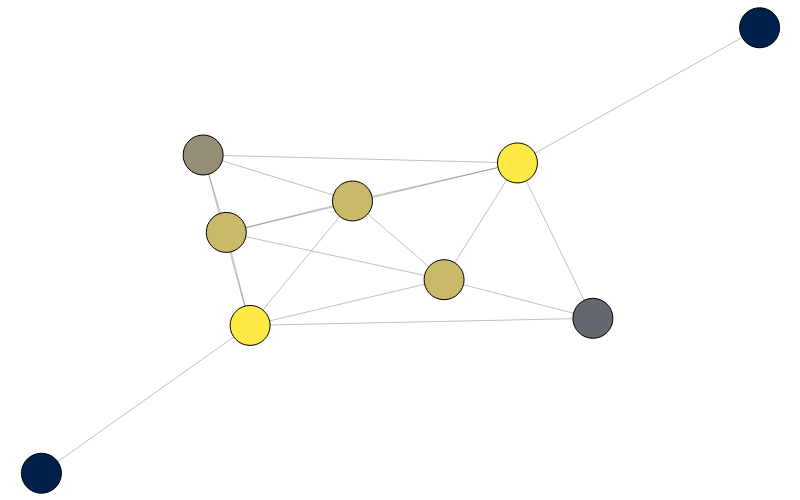

In [65]:
figure_kwargs = {
    'width': 800,
    'height': 500,
    'tooltips': [("degree", "@degree{0.00}"), ("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(degree_graph, color_attribute='degree', **figure_kwargs)
get_screenshot_as_png(plot)

ValueError: Could not save to JPEG for display

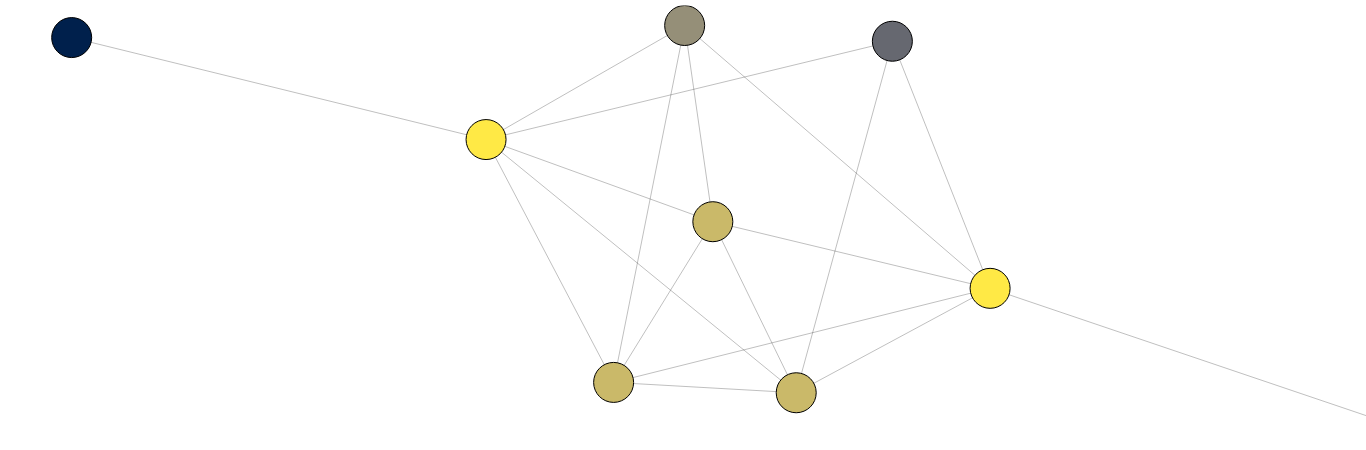

In [66]:
from bokeh.plotting import output_file, save

figure_kwargs = {
    'sizing_mode': 'stretch_width',
    'height': 450,
    'tooltips': [("degree", "@degree{0.00}"), ("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(degree_graph, 'degree', **figure_kwargs)
get_screenshot_as_png(plot)

TBD

## 3. Creating the Network Graphs <a class="anchor" id="creating-network"></a>

TBD

### 3.1 Plots to Embeddings <a class="anchor" id="embeddings"></a>

TBD

In [60]:
similarity_dict = get_similarities_from_json(2010)

similarity_df = get_similarity_df(df.set_index('wikipedia_id'), similarity_dict,  20)
similarity_df.similarity = similarity_df.similarity * 100

similarity_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\EPFL-Everything\\ada-2023-project-adaroundtheworld2023\\data\\embeddings\\similarities\\similarities_2010s.json'

### 3.2 Embeddings to Similarities <a class="anchor" id="similarities"></a>

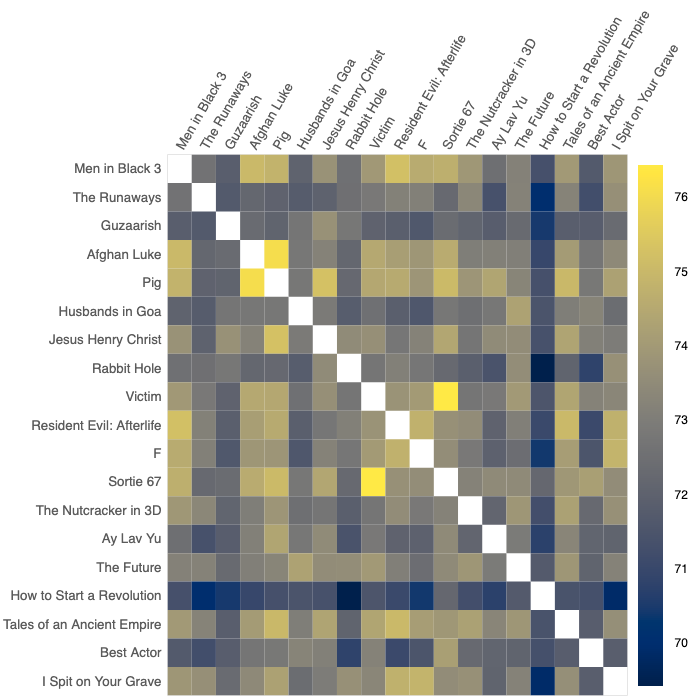

In [ ]:
plot = plot_similarity_matrix(similarity_df, width=700)
get_screenshot_as_png(plot)

### 3.3 Similarities to Graphs <a class="anchor" id="similarities"></a>

In [ ]:
all_ids = list(set(itertools.chain(*similarity_dict.keys())))
wanted_ids = df[df.release_year == 2012].wikipedia_id.unique().tolist()
wanted_combinations = list(itertools.combinations(set(wanted_ids), 2))

similarity_dict_2013 = {}

for movie_1, movie_2 in wanted_combinations:
    try:
        similarity_dict_2013[(movie_1, movie_2)] = similarity_dict[(movie_1, movie_2)]
    except KeyError:
        similarity_dict_2013[(movie_2, movie_1)] = similarity_dict[(movie_2, movie_1)]

<AxesSubplot:title={'center':'Distribution of similarity values'}, ylabel='Frequency'>

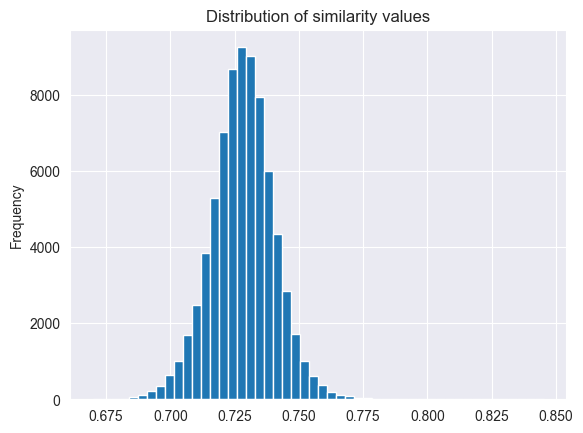

In [ ]:
# check the distribution of similarity values
similarity_values = list(similarity_dict_2013.values())
pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [ ]:
# show descriptive statistics
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    75078.000000
mean         0.728260
std          0.012316
min          0.669865
25%          0.720608
50%          0.728393
75%          0.735918
max          0.845306
dtype: float64

In [ ]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict_2013.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [ ]:
G.number_of_nodes(), G.number_of_edges()

(386, 18770)

In [ ]:
def add_features_from_df(graph, df: pd.DataFrame, features: list):
    graph_df = df.set_index('wikipedia_id')
    
    for feature in features:
        ratings_dict = dict((id_, graph_df.loc[int(id_)][feature]) for id_ in graph.nodes)
        nx.set_node_attributes(graph, name=feature, values=ratings_dict)

    return graph

features_from_df = ['name', 'rating', 'release_year']
G = add_features_from_df(G, df, features_from_df)

# add wikipedia id itself as an attribute
names = dict((id_, int(id_)) for id_ in G.nodes)
nx.set_node_attributes(G, name='wikipedia_id', values=names)

# calculate the betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, name='betweenness', values=betweenness)

# calculate degree for each node
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

# adjusted node size 
adjusted_node_size = dict((key, value * 3.3) for key, value in nx.get_node_attributes(G, "rating").items())
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

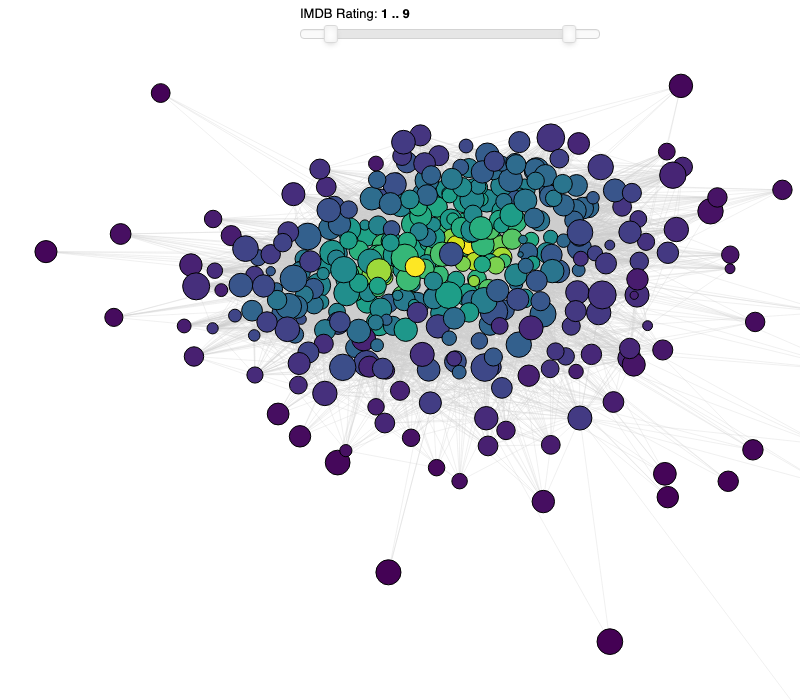

In [ ]:
layout = plot_bokeh_graph(G, sizing_mode='stretch_width', height=700)
get_screenshot_as_png(layout)

### 3.2 Classification <a class="anchor" id="classification"></a>

TBD

#### 3.2.1 Current Genres

In [25]:
# Unique genres
unique_genres = set(itertools.chain(*df.genres.tolist()))
print(f'We have {len(unique_genres)} unique genres.')
print(f'All genres: {unique_genres}')

We have 347 unique genres.
All genres: {'War film', 'Singing cowboy', 'Pornographic movie', 'Addiction Drama', 'Costume Horror', 'Romantic drama', 'The Netherlands in World War II', 'Blaxploitation', "Children's", 'Gulf War', 'Escape Film', 'Teen', 'Plague', 'Crime Drama', 'Master Criminal Films', 'Tragedy', 'Erotica', 'Business', 'Tragicomedy', 'Drama', 'Linguistics', 'Holiday Film', 'Sports', 'Psychological thriller', 'Horror Comedy', 'Coming-of-age film', 'Stand-up comedy', 'Spaghetti Western', 'Historical drama', 'Historical fiction', 'Horse racing', 'Fairy tale', 'Animated cartoon', 'Political cinema', 'Computer Animation', 'Sexploitation', 'Werewolf fiction', 'Comedy Thriller', 'Gender Issues', 'Adventure', 'Caper story', 'Malayalam Cinema', 'Sci-Fi Thriller', 'British New Wave', 'Gay Interest', 'Comedy film', 'Alien Film', 'Film-Opera', 'Erotic thriller', 'Legal drama', 'Martial Arts Film', 'Creature Film', 'Heist', 'Family-Oriented Adventure', 'Roadshow/Carny', 'News', 'Heaven-

##### Excessive and Redundant Genres

Our current dataset suffers from an overabundance of genres. Many of these, such as "Black-and-white" or "Animation," do not directly relate to the plot but rather to the style or technique of the movie.
The presence of subgenres like "Romantic Drama" complicates the genre landscape, as they often represent a mixture of primary genres, making it difficult to maintain clear distinctions.

Text(0.5, 1.0, 'Number of movies by number of genres')

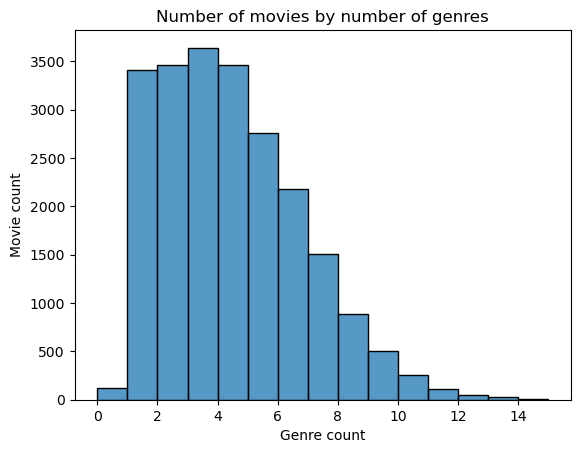

In [26]:
num_genres = df.genres.apply(lambda x: len(x)).rename('genre_count')
ax = sns.histplot(data=num_genres, bins=np.arange(0, 16, 1))

plt.xlabel('Genre count')
plt.ylabel('Movie count')
plt.title('Number of movies by number of genres')

##### Skewed Genre Distribution

The genre distribution in our dataset is heavily skewed, with most movies categorized under 1-6 genres, while some have as many as 16 genres. This uneven distribution poses a challenge for consistent and meaningful genre analysis.

Text(0.5, 1.0, 'Number of movies by genre')

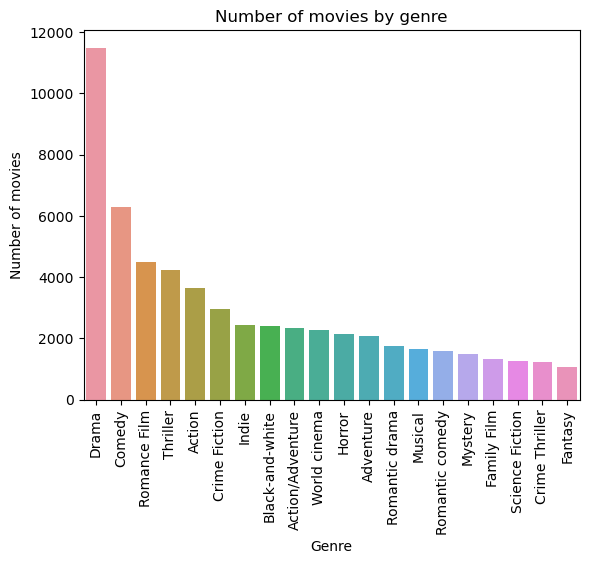

In [27]:
count_min = 1000
genre_count = df.genres.explode().value_counts()
popular_genres = genre_count[genre_count > count_min]

# plot the count of each genre
sns.barplot(x=popular_genres.index, y=popular_genres.values)

plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Number of movies by genre')

##### Entanglement of Popular Genres
Even among the most popular genres, we observe unnecessary entanglement. For instance, while "Comedy" and "Drama" are distinct in the emotions they evoke, genres like "Science-Fiction" or "Crime" often overlap with others such as "Drama" and "Comedy," serving more as settings or themes rather than standalone genres.

#### 3.2.2 Proposed Genres

##### Advantages of a New Genre System

In addressing the challenges with our existing genre classification, the selective use of Language Large Models (LLMs) stands out as a particularly effective solution. By choosing specific genres for the LLM to focus on, we can bypass the issues of an overabundance of genres and the confusion caused by subgenres. This targeted approach enables the LLM to predict genre probabilities accurately based on movie plots, ensuring that the classification is both relevant and plot-centric. Moreover, it helps in normalizing the skewed distribution of genres in our dataset.

##### Splitting Genres and Themes

To enhance the accuracy of our movie classification, we've decided to differentiate between 'genres' and 'themes' for our model's predictions. This distinction allows us to capture both the emotional tone and the narrative setting of each movie more effectively.

**Genres** are selected based on their association with specific emotions or feelings. Our chosen genres are:

* Drama
* Comedy
* Action
* Horror
* Romance
* Thriller
* Adventure
* Documentary

**Themes**, on the other hand, are defined by their focus on particular settings or scenarios. The themes we include are:

* Science-Fiction
* Crime
* Fantasy
* War
* Mystery
* History
* Western
* Family

This bifurcation into genres and themes aims to provide a more nuanced classification, recognizing that the emotional impact of a movie (genre) and its narrative backdrop (theme) are distinct yet equally important aspects of its identity.

The split is also necessary from a model perspective because otherwise the model might be inclined to predict themes rather than genres as they are more related to the plot, which is the only input for the model.



In [28]:
genre_labels = ['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 'Thriller', 'Adventure', 'Documentary']
theme_labels = ['Science-Fiction', 'Crime', 'Fantasy', 'War', 'Mystery', 'History', 'Western', 'Family']

In [46]:
probabilities = get_probabilities_from_json(1910)

To validate our assumption that separating genres and themes will enhance the model's performance, we've designed a classification experiment with a three-pronged approach. First, we classify movies using only genre labels to observe the probability distributions. Second, we repeat the process using only theme labels. Finally, we combine both genre and theme labels in the classification. Our comparison will focus on examining how the genre probability distributions in the first and third scenarios differ, as well as how the theme probability distributions in the second and third scenarios vary.

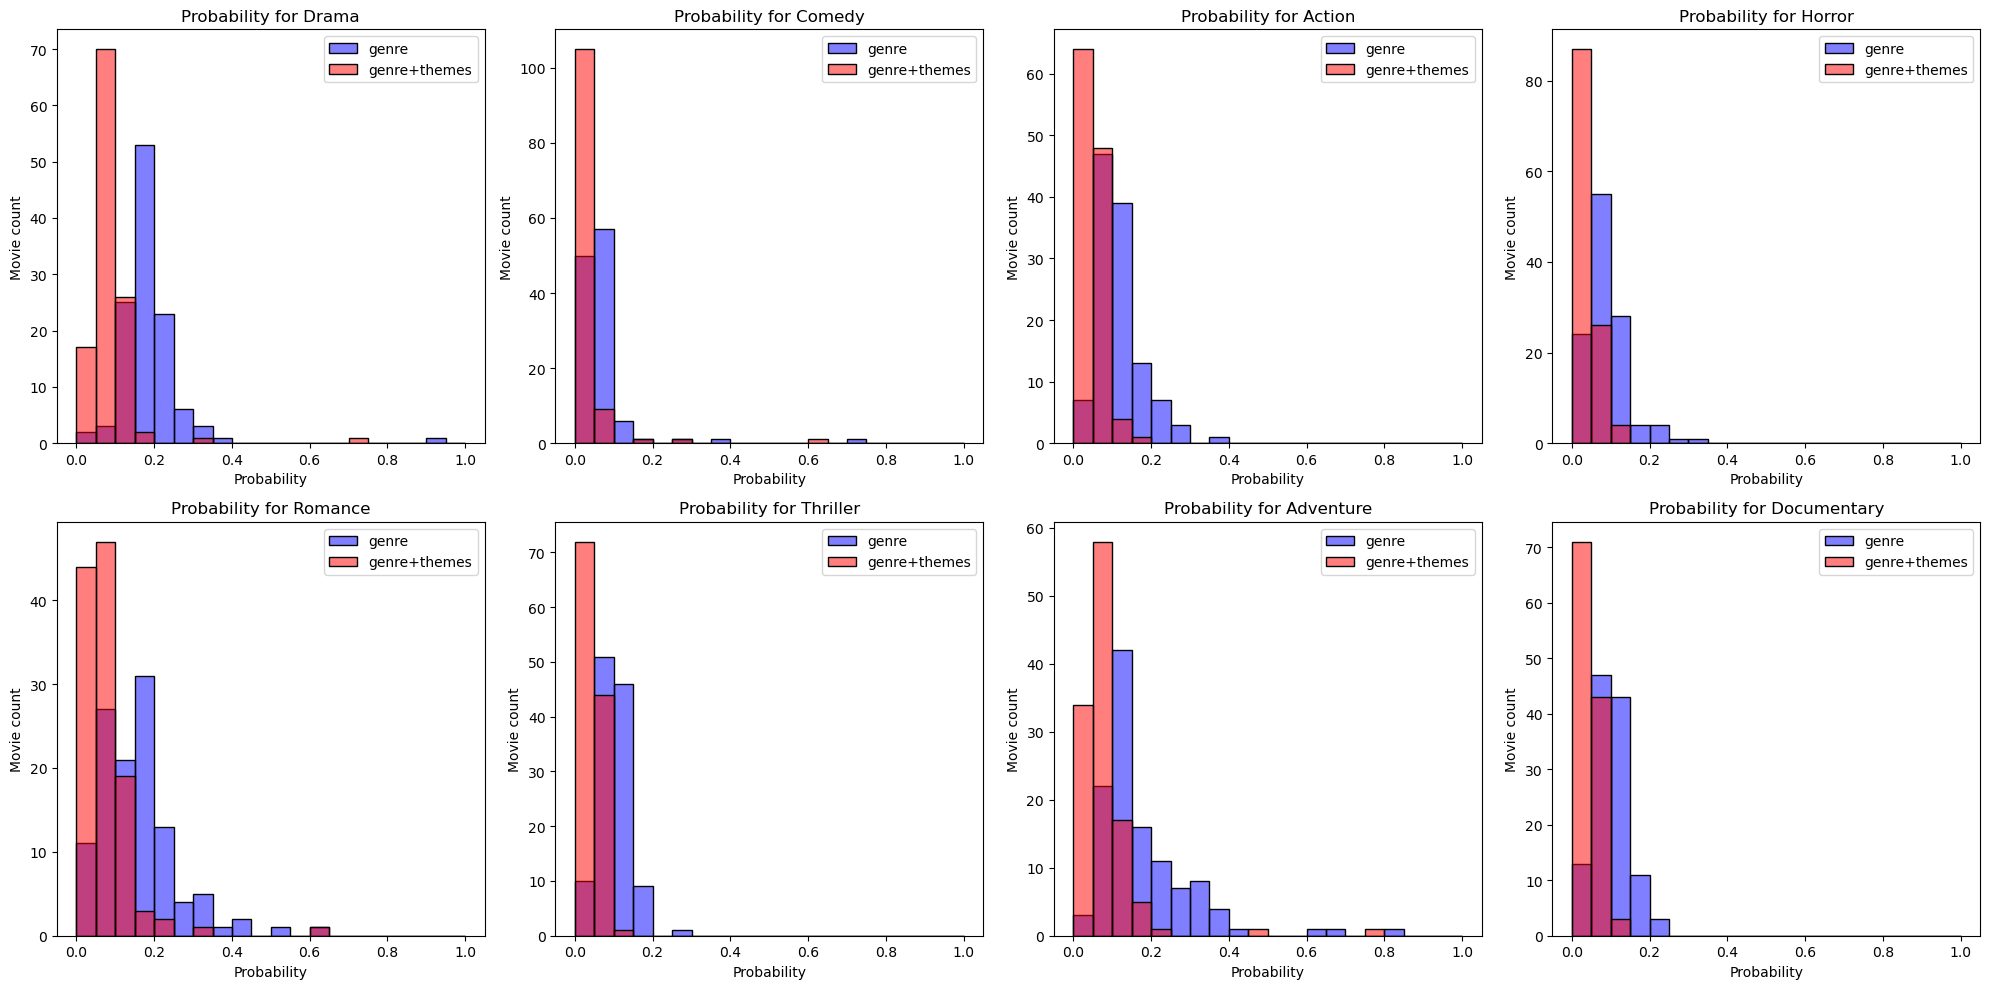

In [47]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, genre in enumerate(genre_labels):

    genre_probs = [probabilities[movie]['genres']['scores'][probabilities[movie]['genres']['labels'].index(genre)] for movie in probabilities.keys()]
    full_probs = [probabilities[movie]['full']['scores'][probabilities[movie]['full']['labels'].index(genre)] for movie in probabilities.keys()]

    sns.histplot(genre_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label='genre', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label='genre+themes', alpha=0.5)
    axes[i].set_title(f'Probability for {genre}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Movie count')
    axes[i].legend()

plt.tight_layout()
plt.show()

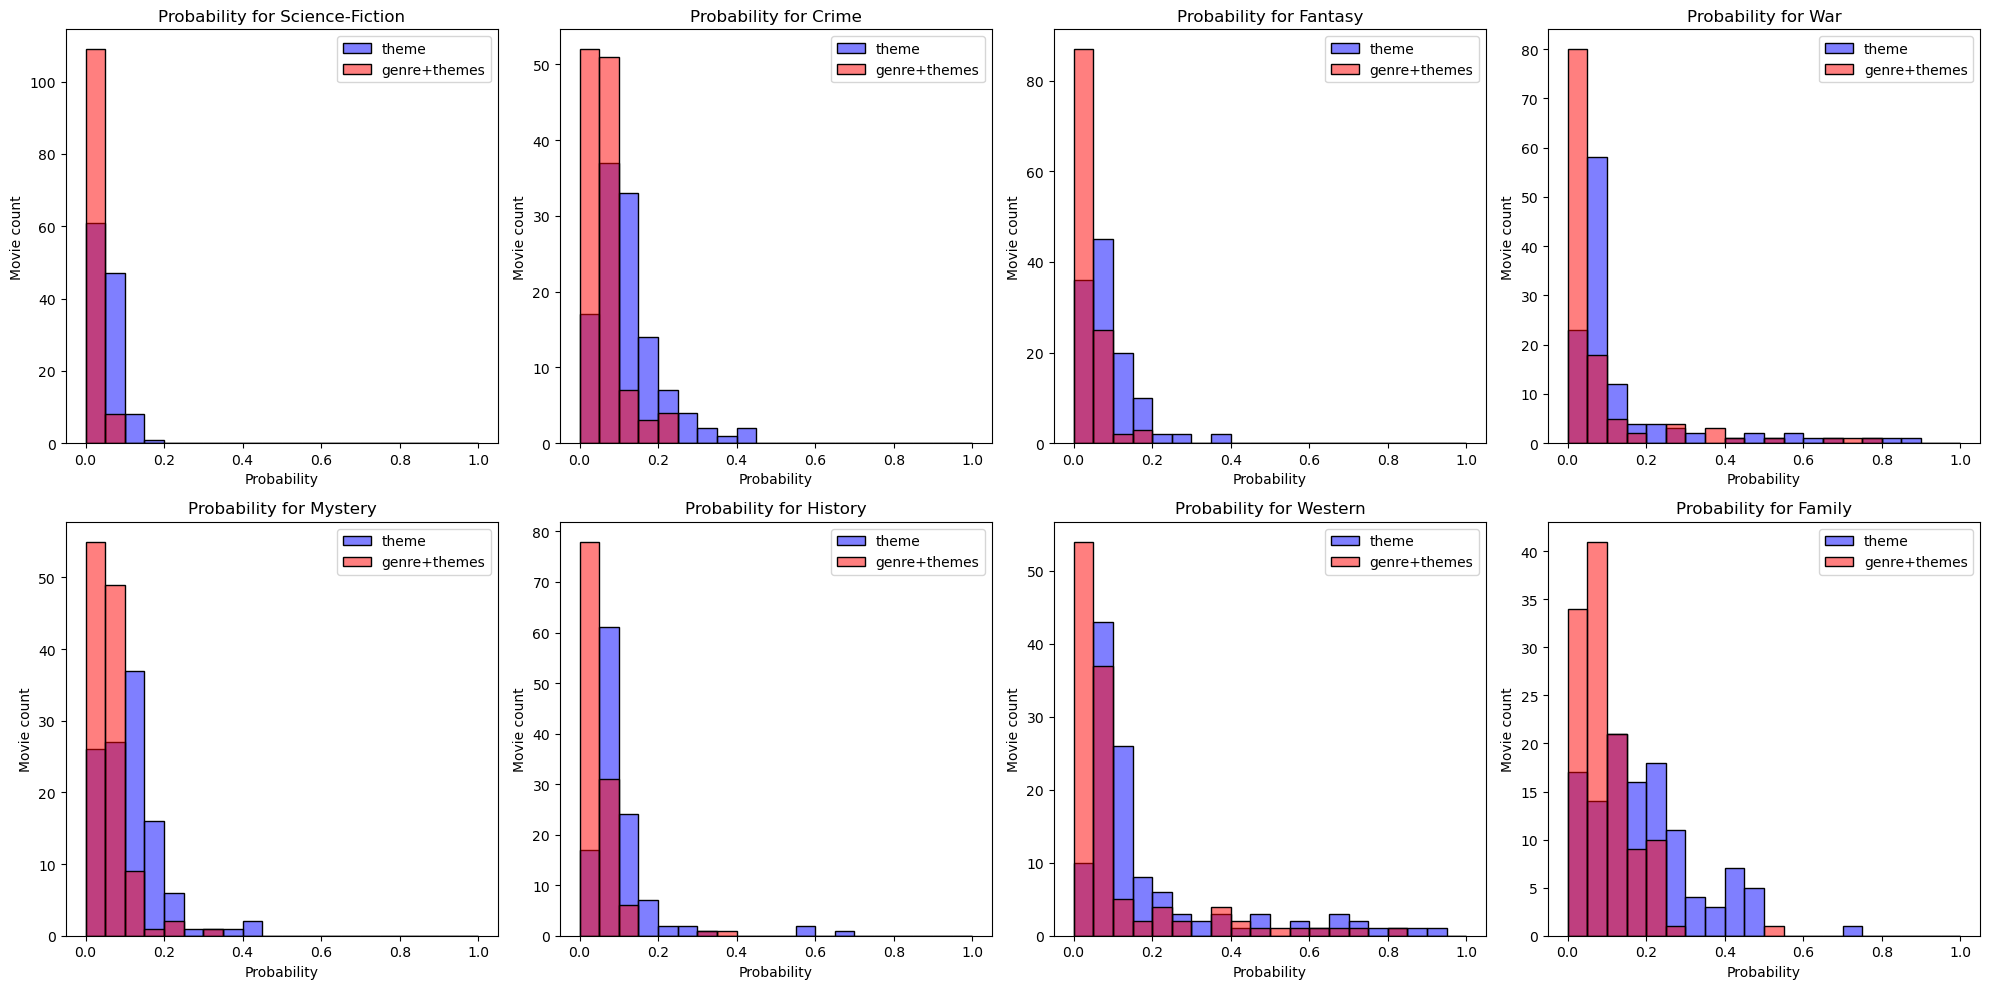

In [48]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, genre in enumerate(theme_labels):
    theme_probs = [probabilities[movie]['themes']['scores'][probabilities[movie]['themes']['labels'].index(genre)] for movie in probabilities.keys()]
    full_probs = [probabilities[movie]['full']['scores'][probabilities[movie]['full']['labels'].index(genre)] for movie in probabilities.keys()]

    sns.histplot(theme_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label='theme', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label='genre+themes', alpha=0.5)
    axes[i].set_title(f'Probability for {genre}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Movie count')
    axes[i].legend()

plt.tight_layout()
plt.show()

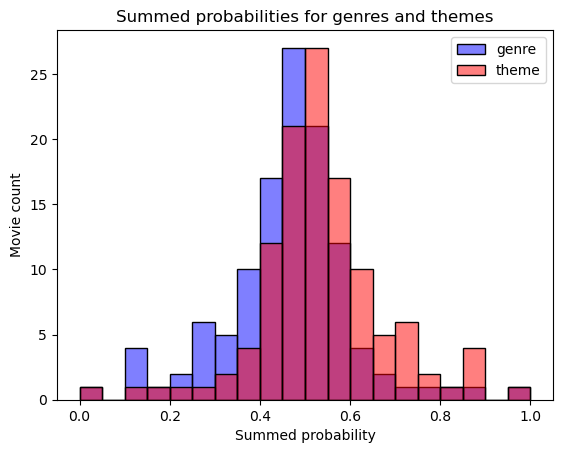

In [49]:
# Let's compare the summed probabilities distribution of genres with those of themes in the same movie

summed_genres = []
summed_themes = []

for movie_id in probabilities.keys():
    summed_genres.append(sum([probabilities[movie_id]['full']['scores'][probabilities[movie_id]['full']['labels'].index(genre)] for genre in genre_labels]))
    summed_themes.append(sum([probabilities[movie_id]['full']['scores'][probabilities[movie_id]['full']['labels'].index(theme)] for theme in theme_labels]))


sns.histplot(summed_genres, bins=np.arange(0, 1.05, 0.05), color='blue', label='genre', alpha=0.5)
sns.histplot(summed_themes, bins=np.arange(0, 1.05, 0.05), color='red', label='theme', alpha=0.5)
plt.xlabel('Summed probability')
plt.ylabel('Movie count')
plt.title('Summed probabilities for genres and themes')
plt.legend()

There will always be some sort of inbalance between the genres and the themes which should not appear as they are different dimensions of classifying a movie. However when we are not splitting them the model will be more inclined to predict themes as they are more related to the plot, which is the only input for the model.

#### 3.2.3 Graph Creation

Now that we have the probabilities for each movie we can look at them as embeddings and use a similar approach as above in order to create the graph. We will create the similarity matrix and then use the threshold to create the graph. We will keep the 75th percentile of the similarities as the threshold.

In [55]:
def embedding_split(movie):
    labels = movie['genres']['labels'] + movie['themes']['labels']
    scores = movie['genres']['scores'] + movie['themes']['scores']
    
    # sort the labels and reorder the scores accordingly
    labels, scores = zip(*sorted(zip(labels, scores)))
    return np.array(scores)

def embedding_full(movie):
    labels = movie['full']['labels']
    scores = movie['full']['scores']
    
    # sort the labels and reorder the scores accordingly
    labels, scores = zip(*sorted(zip(labels, scores)))
    return np.array(scores)

In [54]:
def compute_similarity(probabilities, get_embedding):
    similarity = {}

    for movie_1, movie_2 in tqdm(itertools.combinations(probabilities.keys(), 2)):
        embedding_1 = get_embedding(probabilities[movie_1])
        embedding_2 = get_embedding(probabilities[movie_2])
        similarity[(movie_1, movie_2)] = np.dot(embedding_1, embedding_2)

    return similarity

6786it [00:00, 113976.47it/s]
6786it [00:00, 138438.53it/s]


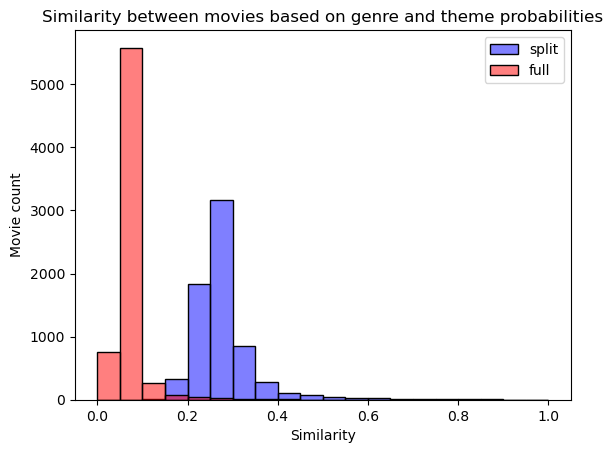

In [58]:
split_similarity = compute_similarity(probabilities, embedding_split)
full_similarity = compute_similarity(probabilities, embedding_full)

sns.histplot(list(split_similarity.values()), bins=np.arange(0, 1.05, 0.05), color='blue', label='split', alpha=0.5)
sns.histplot(list(full_similarity.values()), bins=np.arange(0, 1.05, 0.05), color='red', label='full', alpha=0.5)
plt.xlabel('Similarity')
plt.ylabel('Movie count')
plt.title('Similarity between movies based on genre and theme probabilities')
plt.legend()

Here we see another motivation of splitting between genres and themes, as the similarity distribution is wider when we split the genres and the themes.

In [60]:
def create_graph(similarity):
    descriptive_stats = pd.Series(list(similarity.values())).describe()
    similarity_threshold = descriptive_stats['75%']

    # generate nodes df and add all the pairs with similarity
    similarity_mat = [[key[0], key[1], value] for key, value in similarity.items()]
    nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight'])

    # filter based on 75th percentile
    nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

    G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')
    return G

classification_graph = create_graph(split_similarity)
classification_graph.number_of_nodes(), classification_graph.number_of_edges()

(114, 1697)

<AxesSubplot:ylabel='Count'>

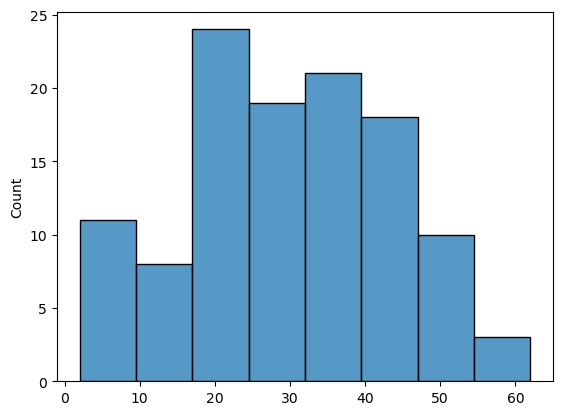

In [63]:
# Show the distribution of degrees

sns.histplot(list(dict(classification_graph.degree).values()))

Based on the distribution of degrees of the graph we can assume a good graph that is quite connected but not too much, averaging around 30 degrees, but having quite a good variance and following more or less a normal distribution.

### 3.4 Using the existing genres for creating the graph

<AxesSubplot:ylabel='Count'>

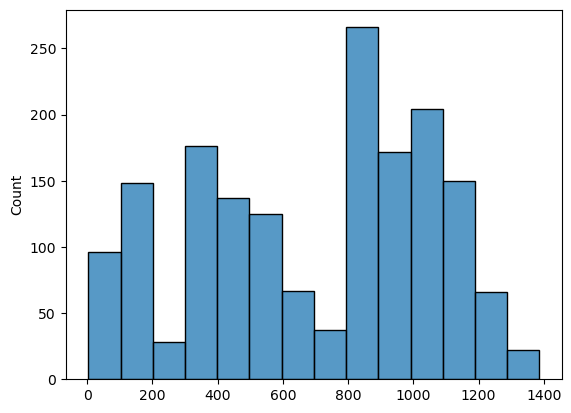

In [64]:
decade = 2010
decade_df = df[(df.release_year >= decade) & (df.release_year < decade + 10)]

graph = nx.Graph()

for idx_1 in range(len(decade_df)):
    for idx_2 in range(idx_1 + 1, len(decade_df)):
        movie_1 = decade_df.iloc[idx_1]
        movie_2 = decade_df.iloc[idx_2]

        if set(movie_1.genres).intersection(movie_2.genres):
            graph.add_edge(movie_1.wikipedia_id, movie_2.wikipedia_id)

sns.histplot(list(dict(graph.degree).values()))

Creating the graph based on the current genres by putting an edge between two movies if they share a genre ends up creating a good distribution of degrees, highly connected while still having a good variance.

## 4. Correlation Analysis <a class="anchor" id="correlation-analysis"></a>

TBD

In [ ]:
decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

dfs = {}  # Dictionary to store the dataframes

for decade in decades:
    G = get_graph_from_pickle(decade)
    df_year = merge_graph_to_df(df.set_index('wikipedia_id'), G) 
    dfs[decade] = df_year

In [ ]:
correlation_df = pd.DataFrame(columns=['degree', 'betweenness'])

for year, df in dfs.items():
    corr_b = df['rating'].corr(df['betweenness'])
    corr_d = df['rating'].corr(df['degree'])
    correlation_df.loc[year] = [corr_d, corr_b]

correlation_df

,degree,betweenness
1920,-0.076025,-0.149805
1930,-0.014151,-0.086933
1940,-0.083260,-0.108408
1950,-0.074576,-0.091050
1960,-0.066483,-0.102074
1970,-0.121390,-0.116902
1980,-0.104128,-0.092801
1990,-0.119577,-0.114067
2000,-0.135006,-0.120756
2010,-0.142755,-0.086834


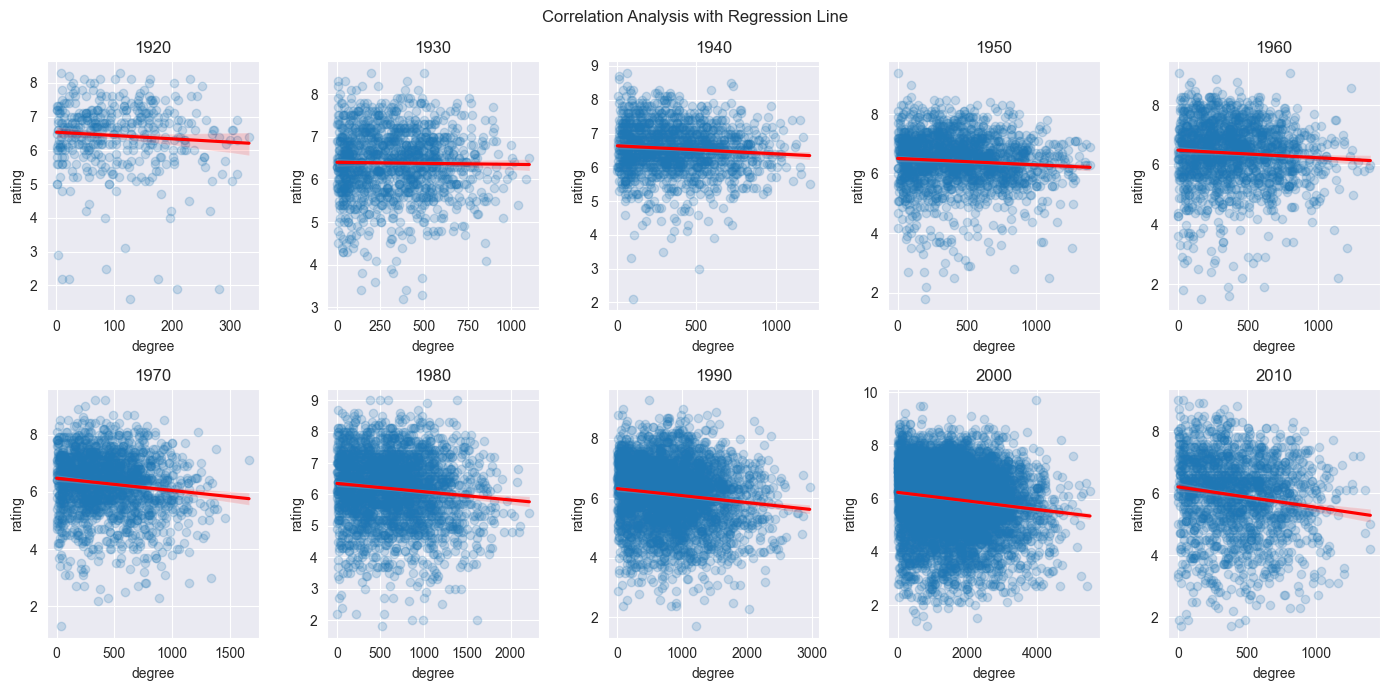

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(14, 7))

decades_as_plot = np.array(decades).reshape(2, 5)
for (row, col), decade in np.ndenumerate(decades_as_plot):
    sns.regplot(
        dfs[decade]['degree'], dfs[decade]['rating'], 
        scatter_kws={'alpha': 0.2}, line_kws={'color': "r"}, ax=axs[row][col]
    )
    axs[row][col].set_title(str(decade))
    
fig.suptitle('Correlation Analysis with Regression Line')
plt.tight_layout();

## Summary  <a class="anchor" id="summary"></a>

TBD